In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

from pathlib import Path
import trimesh
import pyrender
import h5py
import numpy as np
import torch
import os, os.path as osp
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
import cv2
from PIL import Image

from datasets.scannet.utils_3d import ProjectionHelper, adjust_intrinsic, make_intrinsic, load_intrinsic, load_pose
from datasets.scannet.utils_3d import load_depth, load_color
from scripts.sem_seg.prep_backproj_data import get_world_to_scene

In [3]:
def get_scan_name(scene_id, scan_id):
    return f'scene{str(scene_id).zfill(4)}_{str(scan_id).zfill(2)}'

In [4]:
# globals
subvol_size = (32, 32, 32)
voxel_size = 0.05
voxel_dims = (1, 1, 1)
root = Path('/mnt/data/scannet/scans')
proj_img_size = (320, 240)

In [5]:
data_dir = Path('/mnt/data/scannet/backproj')
fname = 'train100-v6.h5'
f = h5py.File(data_dir / fname, 'r')

In [6]:
print(f.keys())
print(f['x'].shape)

<KeysViewHDF5 ['frames', 'scan_id', 'scene_id', 'world_to_grid', 'x', 'y']>
(120100, 32, 32, 32)


In [ ]:
f.close()

In [7]:
# select one sample
ndx = 500
w2g, sceneid, scanid, frames = f['world_to_grid'][ndx], f['scene_id'][ndx], f['scan_id'][ndx], f['frames'][ndx]
print(w2g)
print(sceneid, scanid)
print(frames)
g2w = torch.inverse(torch.Tensor(w2g)).numpy()

subvol_x = f['x'][ndx]
# per-scene basics
scan_name = get_scan_name(sceneid, scanid)
print(scan_name)
scan_path = root / f'{scan_name}/{scan_name}_vh_clean_2.ply'
scan = trimesh.load(scan_path)

# camera and frustum
intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], (40, 30))
focal = (intrinsic[0, 0], intrinsic[1, 1])

[[ 20.   0.   0. -65.]
 [  0.  20.   0. -89.]
 [  0.   0.  20.  -5.]
 [  0.   0.   0.   1.]]
528 0
[280 310 170 260 250]
scene0528_00


In [ ]:
scan_path

## Draw only the scene and camera

In [ ]:
scene = trimesh.scene.scene.Scene() 

pose_path = root / scan_name / 'pose' / f'{frames[0]}.txt'
pose = load_pose(pose_path).numpy()
cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[0]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 

# draw the camera and frustum
camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
camball.apply_transform(pose)
campath.apply_transform(pose)
campath.colors = np.ones((5, 3)) * np.array((0, 255, 0))
scene.add_geometry(camball)
scene.add_geometry(campath)

# the scene mesh
scene.add_geometry(scan)

# axes
axes = trimesh.creation.axis(axis_radius=0.1, axis_length=10)
scene.add_geometry(axes)

scene.show()

## Draw one chunk and its corresponding camera pose(s)

In [ ]:
scene = trimesh.scene.scene.Scene() 

for cam_ndx in range(5):
    pose_path = root / scan_name / 'pose' / f'{frames[cam_ndx]}.txt'
    pose = load_pose(pose_path).numpy()
    cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[cam_ndx]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 

    camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
    camball.apply_transform(pose)
    campath.apply_transform(pose)
    color = (255, 0, 0) if cam_ndx == 0 else (0, 255, 0)
    campath.colors = np.ones((5, 3)) * np.array(color)
    scene.add_geometry(camball)
    scene.add_geometry(campath)

# the scene mesh
scene.add_geometry(scan)

# draw the chunk
# required transform is wrt the center of the box, which is what we have
# hence use the existing g2w
box = trimesh.creation.box(subvol_size, g2w)
print('Add chunk')
scene.add_geometry(box)

# axes
axes = trimesh.creation.axis(axis_radius=0.1, axis_length=10)
print('Add axes')
scene.add_geometry(axes)

scene.show()

## Vis only occupied voxels on mesh

In [ ]:
scene = trimesh.scene.scene.Scene() 

scene.add_geometry(scan)

print('Draw occupied voxels')
for i in tqdm(range(subvol_size[0])):
    for j in range(subvol_size[1]):
        for k in range(subvol_size[2]):
            if subvol_x[i, j, k] == 1:
                # get the transformation of this voxel
                # w2g is wrt center of the chunk, but ijk is wrt a corner of the chunk
                # hence subtract half chunk size from ijk to get "grid coord"
                t = torch.eye(4)
                t[:3, -1] = -(torch.Tensor((i, j, k)) - 16)
                
                voxel_w2g = t @ w2g
                voxel_g2w = torch.inverse(torch.Tensor(voxel_w2g)).numpy()
                box = trimesh.creation.box(voxel_dims, voxel_g2w)
                # make the box blue
                box.visual.face_colors = np.zeros((12, 4)) + (0, 0, 255, 128)
                box.visual.vertex_colors = np.zeros((8, 4)) + (255, 0, 0, 255)
                scene.add_geometry(box)

scene.add_geometry(scan)

# axes
axes = trimesh.creation.axis(axis_radius=0.1, axis_length=10)
scene.add_geometry(axes)

pose_path = root / scan_name / 'pose' / f'{frames[0]}.txt'
pose = load_pose(pose_path).numpy()
cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[0]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 
camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
camball.apply_transform(pose)
campath.apply_transform(pose)
campath.colors = np.ones((5, 3)) * np.array((0, 255, 0))
scene.add_geometry(camball)
scene.add_geometry(campath)

scene.show()

## Viz voxelized scene and occupied voxels

In [ ]:
scene = trimesh.scene.scene.Scene() 

data = torch.load(root / scan_name / f'{scan_name}_occ_grid.pth')
scene_x = data['x']
start_ndx = data['start_ndx']

# world to scene
w2s = get_world_to_scene(voxel_size, -start_ndx)
size = scene_x.shape

for i in tqdm(range(size[0])):
    for j in range(size[1]):
        for k in range(size[2]):
            if scene_x[i, j, k] == 1:
                t = torch.eye(4)
                t[:3, -1] = -(torch.Tensor((i, j, k)))
                
                voxel_w2s = t @ w2s
                voxel_s2w = torch.inverse(torch.Tensor(voxel_w2s)).numpy()
                box = trimesh.creation.box(voxel_dims, voxel_s2w)
                box.visual.face_colors = np.zeros((12, 4)) + (128, 128, 128, 192)
                box.visual.vertex_colors = np.zeros((8, 4)) + (128, 128, 128, 192)
                scene.add_geometry(box)

for i in tqdm(range(subvol_size[0])):
    for j in range(subvol_size[1]):
        for k in range(subvol_size[2]):
            if subvol_x[i, j, k] == 1:
                # get the transformation of this voxel
                # w2g is wrt center of the chunk, but ijk is wrt a corner of the chunk
                # hence subtract half chunk size from ijk to get "grid coord"
                t = torch.eye(4)
                t[:3, -1] = -(torch.Tensor((i, j, k)) - 16)
                
                voxel_w2g = t @ w2g
                voxel_g2w = torch.inverse(torch.Tensor(voxel_w2g)).numpy()
                box = trimesh.creation.box(voxel_dims, voxel_g2w)
                # make the box blue
                box.visual.face_colors = np.zeros((12, 4)) + (0, 0, 255, 192)
                box.visual.vertex_colors = np.zeros((8, 4)) + (255, 0, 0, 192)
                scene.add_geometry(box)

scene.add_geometry(scan)

scene.show()

## Look at the scene from the camera

In [ ]:
render_intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
render_intrinsic = adjust_intrinsic(render_intrinsic, [1296, 968], proj_img_size)
render_focal = (render_intrinsic[0, 0], render_intrinsic[1, 1])
cx, cy = render_intrinsic[0, 2], render_intrinsic[1, 2]
rotx = np.array([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, 1, 0, 0],
    [ 0, 0, 0, 1]
])

# rotx
pose_fixed =  pose @ rotx @ rotx
render_cam = pyrender.IntrinsicsCamera(render_focal[0], render_focal[1], cx, cy, znear=0.4, zfar=4.0, name=None)
render_light = pyrender.DirectionalLight(color=[1.0, 1.0, 1.0], intensity=2.0)
r = pyrender.OffscreenRenderer(viewport_width=proj_img_size[0],
                                viewport_height=proj_img_size[1],
                                point_size=1.0)

### Voxelized Mesh + Occupied Voxels

In [ ]:
# scene with transparent chunk
chunkscene = trimesh.scene.scene.Scene() 
box = trimesh.creation.box(subvol_size, g2w)
box.visual.face_colors = np.zeros((12, 4)) + (255, 0, 0, 192)
box.visual.vertex_colors = np.zeros((8, 4)) + (255, 0, 0, 192)
chunkscene.add_geometry(box)
chunkmesh = chunkscene.dump(concatenate=True)
chunkmesh = pyrender.Mesh.from_trimesh(chunkmesh, smooth=False, wireframe=False)

In [ ]:
voxmesh = scene.dump(concatenate=True)
print(voxmesh)


In [ ]:
pyscene = pyrender.Scene()
pymesh = pyrender.Mesh.from_trimesh(voxmesh, smooth=False)

pyscene.add(pymesh)
pyscene.add(chunkmesh)
pyscene.add(render_cam, pose=pose_fixed)
pyscene.add(render_light, pose=pose_fixed)

rgb_from_pose_vox, _ = r.render(pyscene)
print(rgb_from_pose_vox.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.imshow(rgb_from_pose_vox)
plt.axis('off')


### Original Mesh + Occupied Voxels

In [ ]:
pyscene = pyrender.Scene()
pymesh = pyrender.Mesh.from_trimesh(scan)

pyscene.add(pymesh)
pyscene.add(render_cam, pose=pose_fixed)
pyscene.add(render_light, pose=pose_fixed)

rgb_from_pose, _ = r.render(pyscene)
print(rgb_from_pose.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.imshow(rgb_from_pose)
plt.axis('off')

### Overlay transparent voxels on rendered RGB

In [ ]:
bg = Image.fromarray(rgb_from_pose.astype('uint8'), 'RGB').convert("RGBA")
fg = Image.fromarray(rgb_from_pose_vox.astype('uint8'), 'RGB').convert("RGBA")
overlay_img = np.asarray(Image.blend(bg, fg, 0.6).convert('RGB'))
print(overlay_img.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.imshow(overlay_img)
plt.axis('off')

## project image to voxels and viz correspondences

In [8]:
frame_ndx = 0

In [9]:
pose_path = root / scan_name / 'pose' / f'{frames[frame_ndx]}.txt'
pose = load_pose(pose_path).numpy()

In [ ]:
depth_path = root / scan_name / 'depth' / f'{frames[frame_ndx]}.png' 
# invert dims in the tensor
# N, H, W -> torch nn convention
depth_big = load_depth(depth_path, (640, 480))
print(depth_big.shape)
plt.imshow(depth_big)
plt.axis('off')
plt.colorbar()
print(depth_big.min(), depth_big.max())

(240, 320)
0.0 3.163


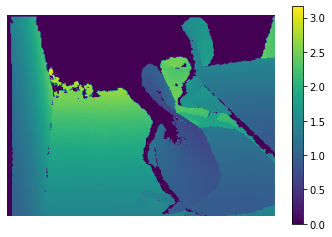

In [10]:
depth_path = root / scan_name / 'depth' / f'{frames[frame_ndx]}.png' 
# invert dims in the tensor
# N, H, W -> torch nn convention
depth = load_depth(depth_path, proj_img_size)
print(depth.shape)
plt.axis('off')
plt.imshow(depth)
plt.colorbar()
print(depth.min(), depth.max())

In [ ]:
# original RGB image
rgb_path = root / scan_name / 'color' / f'{frames[frame_ndx]}.jpg' 
rgb = load_color(rgb_path, (320, 240))
print(rgb.shape)
plt.axis('off')
plt.imshow(rgb.transpose(1, 2, 0))

(3, 240, 320)


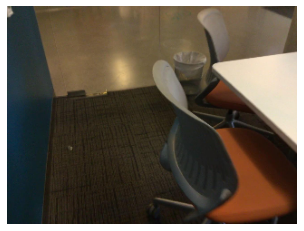

In [11]:
# small RGB image
rgb_path = root / scan_name / 'color' / f'{frames[frame_ndx]}.jpg' 
rgb = load_color(rgb_path, proj_img_size)
print(rgb.shape)
plt.axis('off')
plt.imshow(rgb.transpose(1, 2, 0))

## Draw correspondences between RGB image and scene/voxels

In [12]:
# get projection
intrinsic_path = root / scan_name / 'intrinsic/intrinsic_color.txt'
intrinsic = load_intrinsic(intrinsic_path)
# adjust for smaller image size
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], proj_img_size)

projection = ProjectionHelper(
            intrinsic, 
            0.4, 4.0,
            proj_img_size,
            subvol_size, voxel_size
        )

# projection expects origin of chunk in a corner
# but w2g is wrt center of the chunk -> add 16 to its "grid coords" to get the required grid coords
# ie 0,0,0 becomes 16,16,16
# add an additional translation to existing one 
t = torch.eye(4)
t[:3, -1] = 16
w2g_tmp = t @ w2g

proj3d, proj2d = projection.compute_projection(torch.Tensor(depth), torch.Tensor(pose), torch.Tensor(w2g_tmp))
print(proj3d.shape, proj2d.shape)
num_inds = proj3d[0]
print('Num correspondences:', proj3d[0], proj2d[0])
ind3d = proj3d[1:1+num_inds]
ind2d = proj2d[1:1+num_inds]
print('3d ind range, unique, length', ind3d.min(), ind3d.max(), torch.unique(ind3d).shape, torch.prod(torch.Tensor(subvol_size)))
print('2d ind range, unique, length', ind2d.min(), ind2d.max(), torch.unique(ind2d).shape, torch.prod(torch.Tensor(proj_img_size)))

print('Occupied voxels', (subvol_x == 1).sum())

torch.Size([32769]) torch.Size([32769])
Num correspondences: tensor(1136) tensor(1136)
3d ind range, unique, length tensor(11264) tensor(31633) torch.Size([1136]) tensor(32768.)
2d ind range, unique, length tensor(988) tensor(76742) torch.Size([1125]) tensor(76800.)
Occupied voxels 2740


In [ ]:
# get the ijk coordinates into the chunk (array indices)
coords_3d = torch.empty(4, num_inds)
coords_3d = ProjectionHelper.lin_ind_to_coords_static(ind3d, coords_3d, subvol_size).T[:, :-1].long()
print('3d coords:', coords_3d.shape, coords_3d.dtype)
# viz in red
colors = torch.zeros(num_inds, 3, dtype=int)
colors[:, 0] = (torch.arange(num_inds) * 255 / num_inds).floor()
print('colors:', colors.shape)
print('Coords range', coords_3d.min(axis=0)[0], coords_3d.max(axis=0)[0])

In [ ]:
coords_2d = torch.empty(2, num_inds, dtype=torch.long)
coords_2d = ProjectionHelper.lin_ind2d_to_coords2d_static(ind2d, coords_2d, proj_img_size).T.numpy()

color_2d = np.zeros(proj_img_size[::-1] + (3,), dtype=int)
color_2d[coords_2d[:, 1], coords_2d[:, 0]] = colors
plt.imshow(color_2d)
plt.axis('off')

## draw occupied and mapped voxels with colors

In [ ]:
scene = trimesh.scene.scene.Scene() 

scene.add_geometry(scan)

# get the actual subvol
x = subvol_x
dims = x.shape

print('Draw occupied voxels')
for i in tqdm(range(dims[0])):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if x[i, j, k] == 1:
                # get the transformation of this voxel
                # w2g is wrt center of the chunk, but ijk is wrt a corner of the chunk
                # hence subtract half chunk size from ijk to get "grid coord"
                t = torch.eye(4)
                t[:3, -1] = -(torch.Tensor((i, j, k)) - 16)
                # add an additional translation to existing one
                voxel_w2g = t @ w2g
                voxel_g2w = torch.inverse(torch.Tensor(voxel_w2g)).numpy()
                box = trimesh.creation.box(voxel_dims, voxel_g2w)
                # make the box blue
                box.visual.face_colors = np.zeros((12, 4)) + (0, 0, 255, 128)
                box.visual.vertex_colors = np.zeros((8, 4)) + (0, 0, 255, 255)
                scene.add_geometry(box)

intersection = 0                
print('Draw mapped voxels')
for coord_3d, color in tqdm(zip(coords_3d, colors)): 
    i, j, k = coord_3d.tolist()
    if x[i, j, k] == 1:
        intersection += 1
    # get the transformation of this voxel
    # w2g is wrt center of the chunk, but ijk is wrt a corner of the chunk
    # hence subtract half chunk size from ijk to get "grid coord"
    t = torch.eye(4)
    t[:3, -1] = -(torch.Tensor((i, j, k)) - 16)
    # add an additional translation to existing one
    voxel_w2g = t @ w2g
    voxel_g2w = torch.inverse(torch.Tensor(voxel_w2g)).numpy()
    box = trimesh.creation.box(voxel_dims, voxel_g2w)

    color_tup = tuple(color.tolist())
    box.visual.face_colors = np.zeros((12, 4)) + (color_tup + (128,))
    box.visual.vertex_colors = np.zeros((8, 4)) + (color_tup + (255,))
    scene.add_geometry(box)

print(f'Mapped voxels: {len(coords_3d)}')
print(f'Occupied voxels: {(x == 1).sum()}')
print(f'Mapped and occupied voxels: {intersection} ')

intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], (40, 30))

pose_path = root / scan_name / 'pose' / f'{frames[frame_ndx]}.txt'
pose = load_pose(pose_path).numpy()
focal = (intrinsic[0, 0], intrinsic[1, 1])
cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[frame_ndx]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 
camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
camball.apply_transform(pose)
campath.apply_transform(pose)
campath.colors = np.ones((5, 3)) * np.array((0, 255, 0))
print('Add cam')
scene.add_geometry(camball)
scene.add_geometry(campath)

axes = trimesh.creation.axis(axis_radius=0.1, axis_length=10)
print('Add axes')
scene.add_geometry(axes)

scene.show()

## Viz correspondence b/w mapped voxels and pixels

In [ ]:
def grid_to_pix(grid_ndx, w2g, cam2world, intrinsic, subvol_size):
    '''
    map grid(chunk) indices to pixel coordinates
    '''
    # convert ijk to grid coords, then grid to world and world to cam
    grid_coords = grid_ndx - torch.Tensor(subvol_size)/2  
    # convert to homogenous to use transformation matrix
    grid_coords = torch.cat([grid_coords, torch.ones(len(grid_coords), 1)], dim=-1)
    # apply g2w
    world_coords = torch.Tensor(g2w) @ grid_coords.T
    
    world2cam = torch.inverse(cam2world)
    cam_coords = world2cam @ world_coords
    
    p = cam_coords
    
    x2d = (p[0] * intrinsic[0][0]) / p[2] + intrinsic[0][2]
    y2d = (p[1] * intrinsic[1][1]) / p[2] + intrinsic[1][2]

    pixel_coords = torch.vstack([x2d, y2d]).T.floor().long().numpy()
    
    return pixel_coords    

In [ ]:
# first map the projected voxels to pixel coords and use a single color, should match the previous image
print('Projected voxels:', coords_3d.shape)

x = f['x'][ndx]
dims = x.shape
occ_coords = []
for i in range(dims[0]):
    for j in range(dims[1]):
        for k in range(dims[2]):
            if x[i,j,k] == 1:
                occ_coords.append((i,j,k))
occ_coords = torch.Tensor(occ_coords)
print(f'Occupied voxels:', len(occ_coords))

# read pose
pose_path = root / scan_name / 'pose' / f'{frames[frame_ndx]}.txt'
cam2world = load_pose(pose_path)
# read intrinsic
intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], proj_img_size)

proj_pixelcoords = grid_to_pix(coords_3d, w2g, cam2world, intrinsic, subvol_size)
valid_proj = (proj_pixelcoords[:, 0] >= 0) \
        * (proj_pixelcoords[:, 1] >= 0) \
        * (proj_pixelcoords[:, 0] < proj_img_size[0]) \
        * (proj_pixelcoords[:, 1] < proj_img_size[1])
proj_pixelcoords = proj_pixelcoords[valid_proj]
print('Num valid proj pixels', proj_pixelcoords.shape)
print('Proj Pixel coords range', proj_pixelcoords.min(axis=0), proj_pixelcoords.max(axis=0))

occ_pixelcoords = grid_to_pix(occ_coords, w2g, cam2world, intrinsic, subvol_size)
valid_occ = (occ_pixelcoords[:, 0] >= 0) \
        * (occ_pixelcoords[:, 1] >= 0) \
        * (occ_pixelcoords[:, 0] < proj_img_size[0]) \
        * (occ_pixelcoords[:, 1] < proj_img_size[1])
occ_pixelcoords = occ_pixelcoords[valid_occ]
print('Num valid occ pixels', occ_pixelcoords.shape)
print('Occ Pixel coords range', occ_pixelcoords.min(axis=0), occ_pixelcoords.max(axis=0))

In [ ]:
# show the mapped voxels in 2d
vox_2d = np.zeros(proj_img_size[::-1] + (3,), dtype=np.uint8)
# Y,X / H,W indexing
vox_2d[proj_pixelcoords[:, 1], proj_pixelcoords[:, 0]] = (255, 0, 0)
plt.imshow(vox_2d)
plt.axis('off')

In [ ]:
# show the occupied voxels in 2d
occ_2d = np.zeros(proj_img_size[::-1] + (3,), dtype=np.uint8)
# Y,X / H,W indexing
occ_2d[occ_pixelcoords[:, 1], occ_pixelcoords[:, 0]] = np.array((0, 0, 255), dtype=int)
plt.imshow(occ_2d)
plt.axis('off')

In [ ]:
# viz both in 1 image
both_2d = np.zeros(proj_img_size[::-1] + (3,), dtype=np.uint8)
# Y,X / H,W indexing
both_2d[occ_pixelcoords[:, 1], occ_pixelcoords[:, 0]] = np.array((0, 0, 255), dtype=int)
both_2d[proj_pixelcoords[:, 1], proj_pixelcoords[:, 0]] = (255, 0, 0)
plt.imshow(both_2d)
plt.axis('off')

## Draw point cloud from the camera pose

In [ ]:
def world_to_pix(world_coords, cam2world, intrinsic, subvol_size, img_size):
    '''
    map grid(chunk) indices to pixel coordinates
    img_size: W, H
    '''
    world_coords = torch.cat([world_coords, torch.ones(len(world_coords), 1)], dim=-1).T
    world2cam = torch.inverse(cam2world)
    cam_coords = world2cam @ world_coords
    
    p = cam_coords
    
    x2d = (p[0] * intrinsic[0][0]) / p[2] + intrinsic[0][2]
    y2d = (p[1] * intrinsic[1][1]) / p[2] + intrinsic[1][2]

    # coords within image
    valid_pix = (x2d >= 0) \
                * (y2d >= 0) \
                * (x2d <= img_size[0]) \
                * (y2d <= img_size[1])
    # pick only positive depth
    depth_mask = p[2] > 0
    
    mask = depth_mask * valid_pix
    
    x2d, y2d = x2d[mask], y2d[mask]
    pixel_coords = torch.vstack([x2d, y2d]).T.floor().long().numpy()
    
    return pixel_coords, mask   

In [ ]:
print('Vertices', scan.vertices.shape, scan.visual.vertex_colors.shape)

# read pose
pose_path = root / scan_name / 'pose' / f'{frames[frame_ndx]}.txt'
cam2world = load_pose(pose_path)
# read intrinsic
intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], proj_img_size)

print(scan.vertices.min(axis=0), scan.vertices.max(axis=0))

pc_pixelcoords, mask = world_to_pix(torch.Tensor(scan.vertices), cam2world, intrinsic, subvol_size, proj_img_size)
print('Num PC pixels', pc_pixelcoords.shape)
print('PC Pixel coords range', pc_pixelcoords.min(axis=0), pc_pixelcoords.max(axis=0))
pc_colors = scan.visual.vertex_colors[mask][:, :3]
print('New colors', pc_colors.shape)


In [ ]:
# show the point cloud (vertices) from the chosen pose in 2d
pc_2d = np.ones(proj_img_size[::-1] + (3,), dtype=np.uint8) * 255
# Y,X / H,W indexing
pc_2d[pc_pixelcoords[:, 1], pc_pixelcoords[:, 0]] = pc_colors
plt.imshow(pc_2d)
plt.axis('off')

## Draw one chunk and 2 RGBs
- Project 2 different frames to the same chunk
- Pick the voxels that are seen by both images
- Draw the chunk as seen by the 1st image, and draw correspondences to both images

In [ ]:
def load_everything(scan_name, frame, proj_img_size):
    pose_path = root / scan_name / 'pose' / f'{frame}.txt'
    pose = load_pose(pose_path)
    depth_path = root / scan_name / 'depth' / f'{frame}.png' 
    depth = load_depth(depth_path, proj_img_size)
    rgb_path = root / scan_name / 'color' / f'{frame}.jpg' 
    rgb = load_color(rgb_path, proj_img_size)
    
    return pose, depth, rgb

In [ ]:
def draw_corresp_multiview(x, frame1, frame2, scan_name, proj_img_size, w2g, common_img, match_inds=None, n_matches=None):
    pose1, depth1, rgb1 = load_everything(scan_name, frame1, proj_img_size)
    pose2, depth2, rgb2 = load_everything(scan_name, frame2, proj_img_size)
    intrinsic_path = root / scan_name / 'intrinsic/intrinsic_color.txt'
    intrinsic = load_intrinsic(intrinsic_path)
    # adjust for smaller image size
    intrinsic = adjust_intrinsic(intrinsic, [1296, 968], proj_img_size)
    
    projection = ProjectionHelper(
            intrinsic, 
            0.4, 4.0,
            proj_img_size,
            subvol_size, voxel_size
        )
    t = torch.eye(4)
    t[:3, -1] = 16
    w2g_tmp = t @ w2g
    
    proj3d1, proj2d1 = projection.compute_projection(torch.Tensor(depth1), torch.Tensor(pose1), torch.Tensor(w2g_tmp))
    num_inds1 = proj3d1[0]
    ind3d1 = proj3d1[1:1+num_inds1]
    ind2d1 = proj2d1[1:1+num_inds1]
    
    proj3d2, proj2d2 = projection.compute_projection(torch.Tensor(depth2), torch.Tensor(pose2), torch.Tensor(w2g_tmp))
    num_inds2 = proj3d2[0]
    ind3d2 = proj3d2[1:1+num_inds2]
    ind2d2 = proj2d2[1:1+num_inds2]
    
    # voxels seen by rgb1
    coords_3d1 = torch.empty(4, num_inds1)
    coords_3d1 = ProjectionHelper.lin_ind_to_coords_static(ind3d1, coords_3d1, subvol_size).T[:, :-1].long()            
    # pick the ones that are seen by rgb2 as well
    proj_pixelcoords2 = grid_to_pix(coords_3d1, w2g, pose2, intrinsic, subvol_size)
    # should lie within the image1
    valid_in2 = (proj_pixelcoords2[:, 0] >= 0) \
            * (proj_pixelcoords2[:, 1] >= 0) \
            * (proj_pixelcoords2[:, 0] < proj_img_size[0]) \
            * (proj_pixelcoords2[:, 1] < proj_img_size[1])
    proj_pixelcoords2 = proj_pixelcoords2[valid_in2]
    
    # pick only these points in rgb1
    proj_pixelcoords1 = grid_to_pix(coords_3d1, w2g, pose1, intrinsic, subvol_size)
    proj_pixelcoords1 = proj_pixelcoords1[valid_in2]
    ######################################################################
    # voxel indices that are occupied
    dims = x.shape
    occ_coords = []
    for i in range(dims[0]):
        for j in range(dims[1]):
            for k in range(dims[2]):
                if x[i,j,k] == 1:
                    occ_coords.append((i,j,k))
    occ_coords = torch.Tensor(occ_coords)
    # corresponding pixel coords
    occ_pixelcoords = grid_to_pix(occ_coords, w2g, pose1, intrinsic, subvol_size)
    # should lie within the image1
    valid_occ_in1 = (occ_pixelcoords[:, 0] >= 0) \
            * (occ_pixelcoords[:, 1] >= 0) \
            * (occ_pixelcoords[:, 0] < proj_img_size[0]) \
            * (occ_pixelcoords[:, 1] < proj_img_size[1])
    occ_pixelcoords = occ_pixelcoords[valid_occ_in1]
    
    # 2d image with occupied voxels
    occ_2d1 = np.zeros(proj_img_size[::-1] + (3,), dtype=np.uint8)
    occ_2d1[occ_pixelcoords[:, 1], occ_pixelcoords[:, 0]] = np.array((0, 0, 255), dtype=int)
    ######################################################################
    # the set of common voxels to show in each rgb
    if n_matches:
        # pick matches
        match_inds = torch.randperm(len(proj_pixelcoords2))[:n_matches]
    else:
        # match indices are supplied
        assert match_inds is not None
        n_matches = len(match_inds)
    matches = torch.arange(n_matches).repeat(2, 1).T
    ######################################################################
    # viz1
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.axis('off')
    
    match_coords1 = proj_pixelcoords1[match_inds]
    # interchange X and Y
    match_coords1 = np.vstack([match_coords1[:, 1], match_coords1[:, 0]]).T

    plot_matches(ax, np.transpose(rgb1, (1, 2, 0)), common_img, match_coords1, match_coords1, matches,
                 only_matches=False, keypoints_color='white', matches_color='red')
    ######################################################################
    # viz2
    match_coords2 = proj_pixelcoords2[match_inds]
    # interchange X and Y
    match_coords2 = np.vstack([match_coords2[:, 1], match_coords2[:, 0]]).T
    
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    plt.axis('off')
    plot_matches(ax, np.transpose(rgb2, (1, 2, 0)), common_img, match_coords2, match_coords1, matches,
                 only_matches=False, keypoints_color='white', matches_color='red')

In [ ]:
frame1, frame2 = frames[0], frames[2]
draw_corresp_multiview(x, frame1, frame2, scan_name, proj_img_size, w2g, scene_with_voxels_rgb, match_inds=match_inds)

## Draw matches between RGB and rendered PC

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.axis('off')
# select a few correspondences to draw
n_matches = 8
match_inds = torch.randperm(len(proj_pixelcoords))[:n_matches]
match_coords = proj_pixelcoords[match_inds]
# interchange X and Y
match_coords = np.vstack([match_coords[:, 1], match_coords[:, 0]]).T
matches = torch.arange(n_matches).repeat(2, 1).T

plot_matches(ax, np.transpose(rgb, (1, 2, 0)), overlay_img, match_coords, match_coords.copy(), matches,
             only_matches=False, keypoints_color='white', matches_color='red')

In [ ]:
len(proj_pixelcoords), len(coords_3d), len(colors)

### Draw only the selected matched voxels in 3D

In [ ]:
coords_3d_valid = coords_3d[valid_proj]
coords_3d_viz = coords_3d_valid[match_inds]

rotx = np.array([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, 1, 0, 0],
    [ 0, 0, 0, 1]
])

roty = np.array([
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [-1, 0, 0, 0],
    [ 0, 0, 0, 1]
])

rotz = np.array([
    [0, -1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [ 0, 0, 0, 1]
])

# # rotx
pose_tmp = pose_fixed @ rotz #@ rotz

cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[cam_ndx]}', resolution=proj_img_size, focal=render_focal, z_near=0.4, z_far=4.0)
scene = trimesh.scene.scene.Scene(camera=cam, camera_transform=pose_fixed) 

print('Draw subset of mapped voxels')
for coord_3d, color in tqdm(zip(coords_3d_viz, colors)): 
    i, j, k = coord_3d.tolist()
    # get the transformation of this voxel
    # w2g is wrt center of the chunk, but ijk is wrt a corner of the chunk
    # hence subtract half chunk size from ijk to get "grid coord"
    t = torch.eye(4)
    t[:3, -1] = -(torch.Tensor((i, j, k)) - 16)
    # add an additional translation to existing one
    voxel_w2g = t @ w2g
    voxel_g2w = torch.inverse(torch.Tensor(voxel_w2g)).numpy()
    box = trimesh.creation.box(voxel_dims, voxel_g2w)

    color_tup = tuple(color.tolist())
    box.visual.face_colors = np.zeros((12, 4)) + ((255, 0, 0, 255))
    box.visual.vertex_colors = np.zeros((8, 4)) + ((255, 0, 0, 255))
    scene.add_geometry(box)

# scene.add_geometry(scan)
    
scene.show()

In [ ]:
pose_fixed@roty, pose_fixed@rotz

### render mesh+few voxels from camera

In [ ]:
pyscene = pyrender.Scene()
voxels_mesh = scene.dump(concatenate=True)

pyscene.add(pyrender.Mesh.from_trimesh(voxels_mesh, smooth=False))
pyscene.add(pyrender.Mesh.from_trimesh(scan))
pyscene.add(render_cam, pose=pose_fixed)
pyscene.add(render_light, pose=pose_fixed)

scene_with_voxels_rgb, _ = r.render(pyscene)
print(scene_with_voxels_rgb.shape)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
plt.imshow(scene_with_voxels_rgb)
plt.axis('off')


### Draw correspondences RGB--mesh+voxels

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.axis('off')
plot_matches(ax, np.transpose(rgb, (1, 2, 0)), scene_with_voxels_rgb, match_coords, match_coords.copy(), matches,
             only_matches=False, keypoints_color='white', matches_color='red')

## Draw all the cameras in a scene

In [ ]:
# draw all cameras in a scene
scene = trimesh.scene.scene.Scene() 

scan_name = get_scan_name(sceneid, scanid)
print(scan_name)
root = Path('/mnt/data/scannet/scans')
scan_path = root / f'{scan_name}/{scan_name}_vh_clean_2.ply'
scan = trimesh.load(scan_path)
print(scan)
print('Add scan')
scene.add_geometry(scan)

box = trimesh.creation.box(subvol_size, g2w)
print('Add box')
scene.add_geometry(box)

intrinsic = make_intrinsic(1170.187988, 1170.187988, 647.75, 483.75)
intrinsic = adjust_intrinsic(intrinsic, [1296, 968], (40, 30))
pose_files = sorted(os.listdir(root / scan_name / 'pose'), key=lambda f: int(osp.splitext(f)[0]))
pose_indices = range(0, len(pose_files), frame_skip)
print('Add poses:', len(pose_indices))
frame_skip = 40
focal = (intrinsic[0, 0], intrinsic[1, 1]) 
for ndx, pose_ndx in enumerate(tqdm(pose_indices)):
    pose_path = root / scan_name / 'pose' / pose_files[pose_ndx]
    pose = load_pose(pose_path).numpy()
    
    cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[0]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 
    camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
    
    camball.apply_transform(pose)
    campath.apply_transform(pose)
    campath.colors = np.zeros((5, 3))
    scene.add_geometry(camball)
    scene.add_geometry(campath)

# draw the best pose in a different color
pose_path = root / scan_name / 'pose' / f'{frames[0]}.txt'
pose = load_pose(pose_path).numpy()
focal = (intrinsic[0, 0], intrinsic[1, 1])
cam = trimesh.scene.Camera(name=f'{scan_name}_{frames[0]}', resolution=(40, 30), focal=focal, z_near=0.4, z_far=4.0) 
camball, campath = trimesh.creation.camera_marker(cam, marker_height=4, origin_size=0.05)
camball.apply_transform(pose)
campath.apply_transform(pose)
# green
campath.colors = np.ones((5, 3)) * np.array((0, 255, 0))
print('Add cam')
scene.add_geometry(camball)
scene.add_geometry(campath)

axes = trimesh.creation.axis(axis_radius=0.1, axis_length=10)
print('Add axes')
scene.add_geometry(axes)

scene.show()